---
title: "Lab Project AYA"
author: "Safia safa-tahar-henni"
date: "January 28, 2019"

---

# AYA Project

Les donnees proviennent de plusieurs sources:
* Leucegene:
500 patients dont 80 AYA
donnees:  p-value analyse expression differentielle
non normalise 
analyse avec DeSeq2
* TGCA: ~ 200 adultes
* Target (https://ocg.cancer.gov/programs/target/projects/acute-myeloid-leukemia):
Les chercheurs de TARGET analysent les tumeurs de patients pediatriques, dont beaucoup ont fait une rechute, afin d'identifier des biomarqueurs en correlation avec de mauvais resultats cliniques et / ou de nouvelles approches therapeutiques pour traiter la LMA chez l'enfant. (200 patients)


But : Analyse expression differentielle, mettre en evidence des genes specifique aux Adolescents et jeunes Adultes (18-40 ans).



In [2]:
#if (!requireNamespace("BiocManager", quietly = TRUE))
#    install.packages("BiocManager")
#BiocManager::install("DESeq2", version = "3.8")
library("DESeq2")
#BiocManager::install("genefilter", version = "3.8")
library(genefilter)

In [3]:
library('plyr') #package pour table de comptage
library(magrittr)
library("varhandle")
#library(tidyr)


Attaching package: ‘plyr’

The following object is masked from ‘package:matrixStats’:

    count

The following object is masked from ‘package:IRanges’:

    desc

The following object is masked from ‘package:S4Vectors’:

    rename



## Repartition des echantillons selon leurs caracteristiques cliniques

In [4]:
data_API = read.csv("/home/safia/Documents/AYA/Leucegene risk complete.txt",header = T,sep = "\t")
data_API<- data.frame(data_API[,-1], row.names=data_API[,1])

t_data_API = as.data.frame(t(data_API)) # inverse colonne ligne
colnames(t_data_API) <- gsub(" ","_",colnames(t_data_API)) # remplace les espaces dans le nom des colonnes
t_data_API <- head(t_data_API, -1) # supprimme la deriniere ligne data_type 
summary(t_data_API)


 Age_at_diagnosis LSC_frequency Overall_Survival_Status
 -      :129            : 15    -  :129                
 nan    : 41      -     :129    0  :114                
 65     : 22      High  : 10    1  :338                
 56     : 16      Low   : 23    nan: 41                
 58     : 15      Medium: 21                           
 68     : 14      nan   :424                           
 (Other):385                                           
                                                                                                    Subgroup  
 Normal karyotype                                                                                       :248  
 Intermediate abnormal karyotype (except isolated trisomy/tetrasomy 8)                                  : 88  
 Complex (3 and more chromosomal abnormalities)                                                         : 72  
 MLL translocations (+MLL FISH positive) (Irrespective of additional cytogenetic abnormalities)         : 37

### Cytogenetic risk

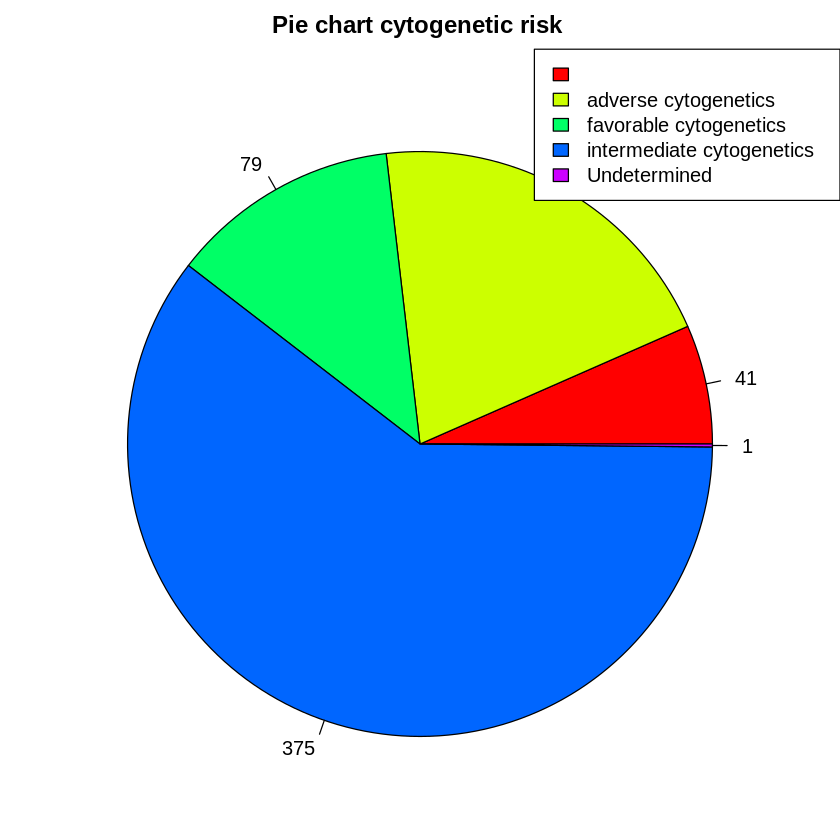

In [5]:

# count table
count_cytogenetic_risk = count(t_data_API,"cytogenetic_risk " )

# Pie chart
par(xpd=TRUE, mar=c(0,0,2,0))
pie(count_cytogenetic_risk$freq, main = "Pie chart cytogenetic risk ",labels = count_cytogenetic_risk$freq, col = rainbow(length(count_cytogenetic_risk$freq)))
legend("topright",legend = count_cytogenetic_risk$cytogenetic_risk, cex = 1,ncol = 1,
       fill = rainbow(length(count_cytogenetic_risk$freq)),xpd=NA)


### Cytogenetic subgroup

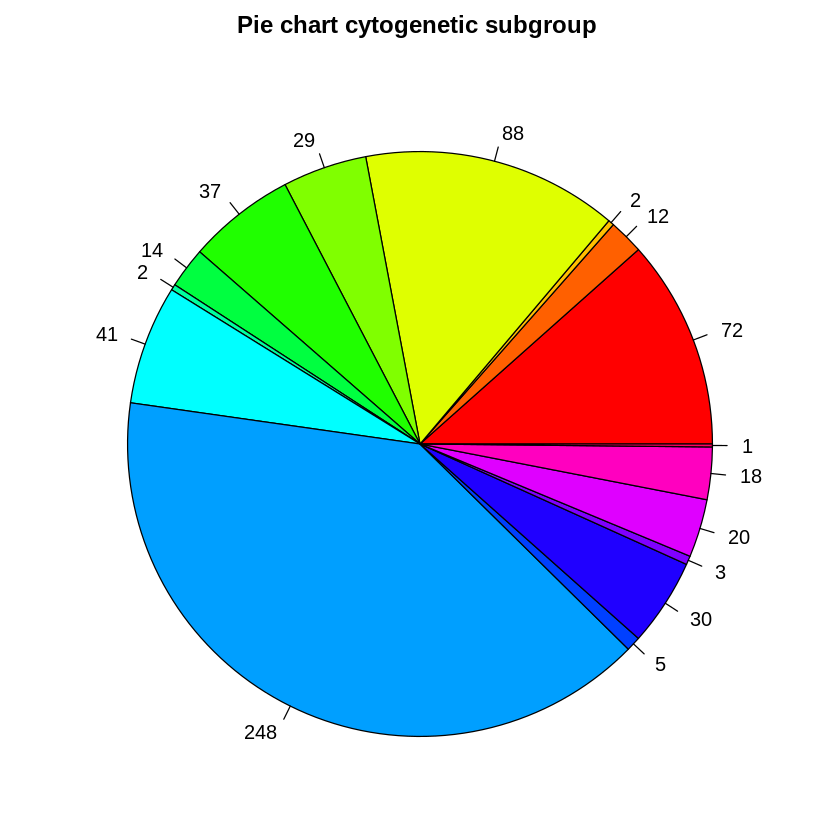

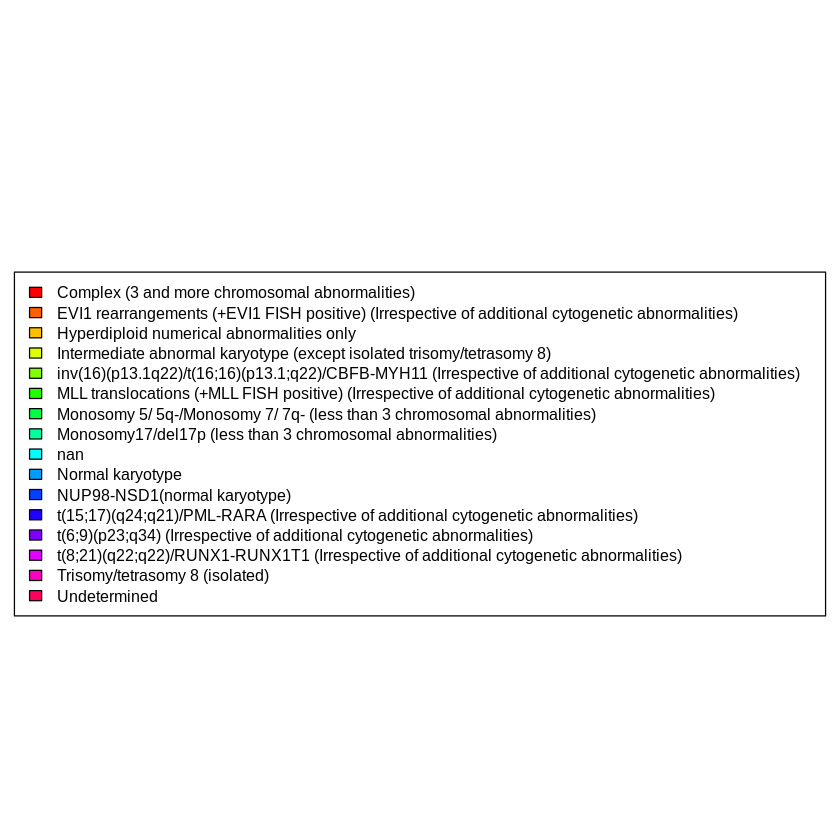

In [5]:
# count table
count_cytogenetic_subgroup = count(t_data_API, "cytogenetic_subgroup")

# Pie chart
par(xpd=TRUE, mar=c(0,0,2,0))
pie(count_cytogenetic_subgroup$freq, main = "Pie chart cytogenetic subgroup ",labels = count_cytogenetic_subgroup$freq, col = rainbow(length(count_cytogenetic_subgroup$freq)))

plot(1,type="n",axes=FALSE,xlab="",ylab="")
legend("center",legend = count_cytogenetic_subgroup$cytogenetic_subgroup, cex = 0.8,ncol = 1,
       fill = rainbow(length(count_cytogenetic_subgroup$freq)),xpd=NA)


### Subgroup

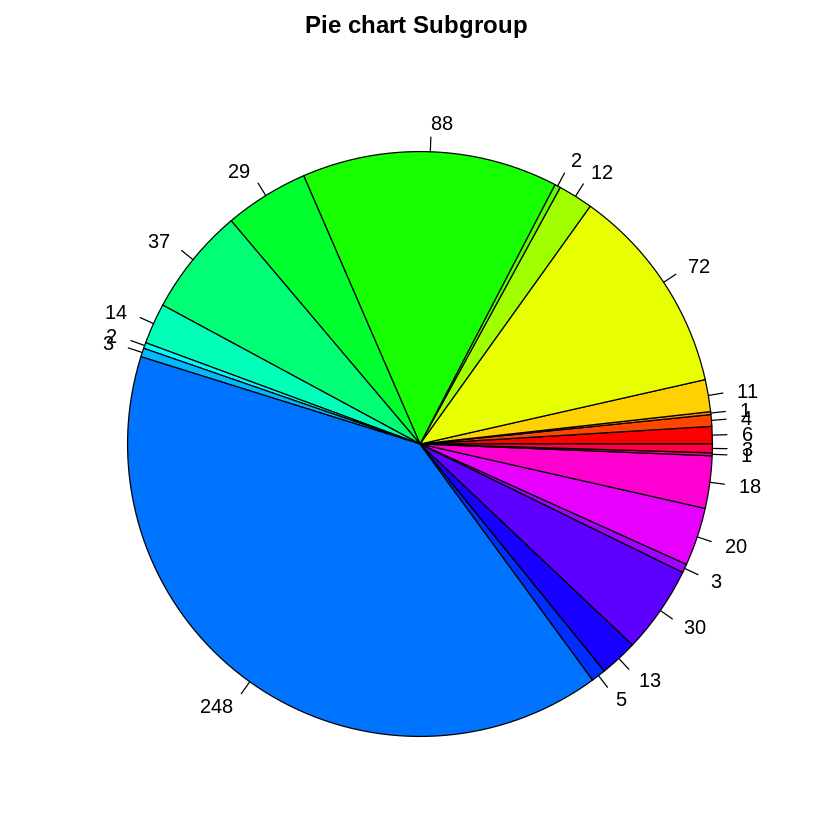

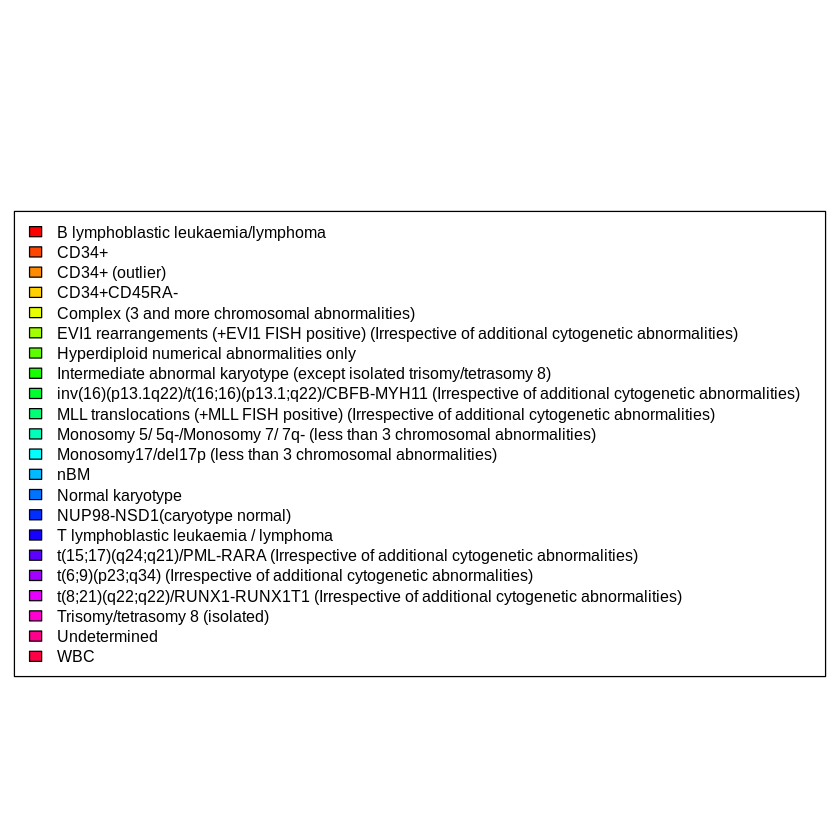

In [6]:
# count table
count_Subgroup = count(t_data_API, "Subgroup")

# Pie chart
par(xpd=TRUE, mar=c(0,0,2,0))
pie(count_Subgroup$freq, main = "Pie chart Subgroup ",labels = count_Subgroup$freq, col = rainbow(length(count_Subgroup$freq)))

plot(1,type="n",axes=FALSE,xlab="",ylab="")
legend("center",legend = count_Subgroup$Subgroup, cex = 0.8,ncol = 1,
       fill = rainbow(length(count_Subgroup$freq)),xpd=NA)

### WHO 2008

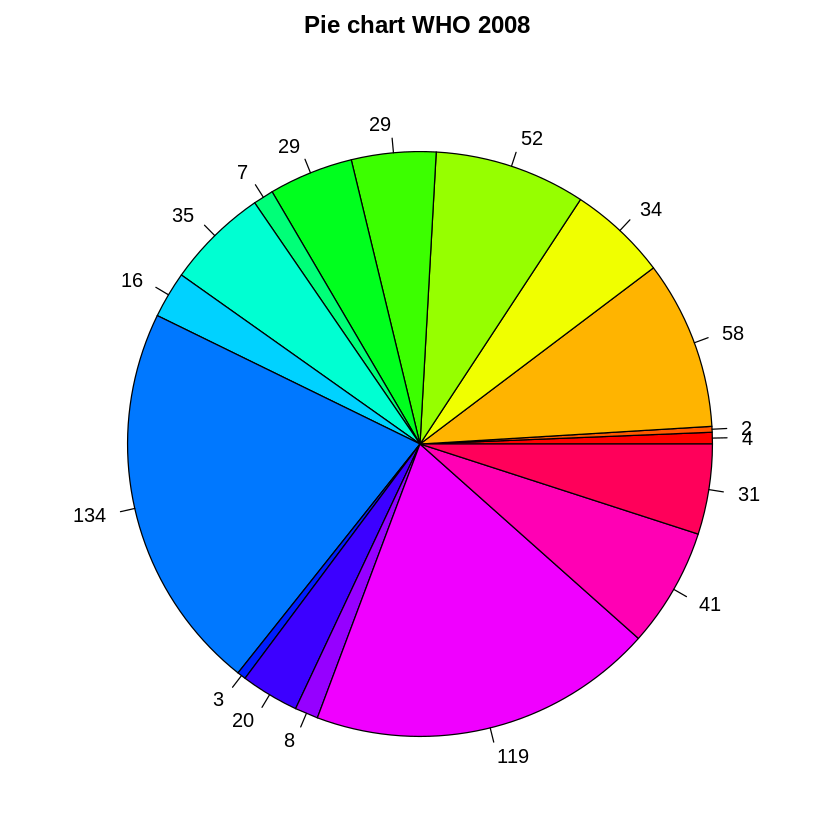

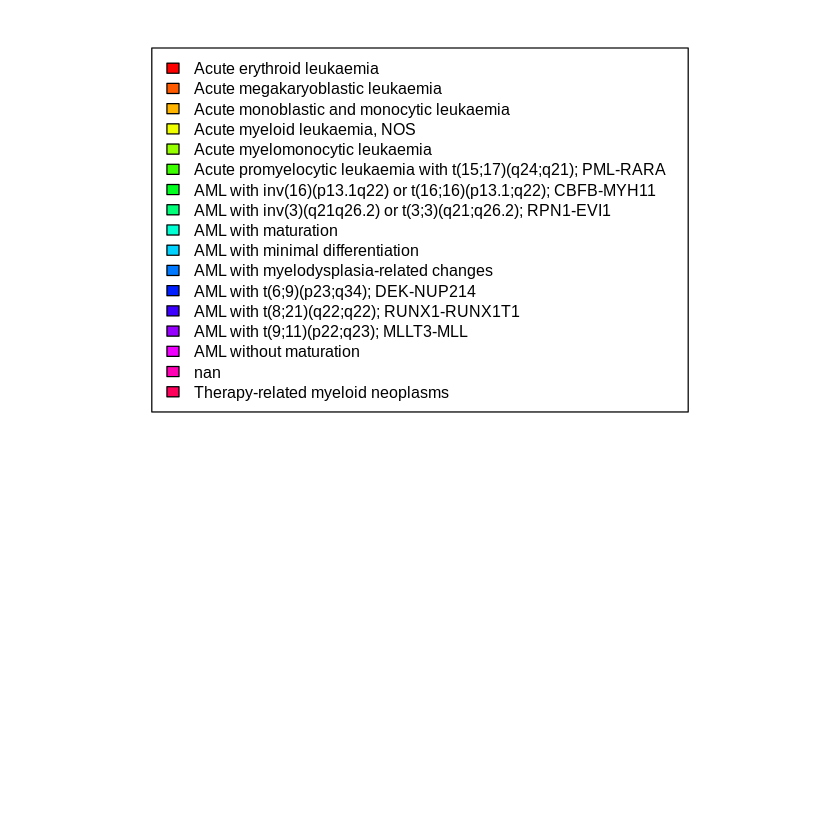

In [7]:
# count table
count_Who = count(t_data_API, "WHO_2008")

# Pie chart
par(xpd=TRUE, mar=c(0,0,2,0))
pie(count_Who$freq, main = "Pie chart WHO 2008 ",labels = count_Who$freq, col = rainbow(length(count_Who$freq)))
plot(1,type="n",axes=FALSE,xlab="",ylab="")
legend("top",legend = count_Who$WHO_2008, cex = 0.8,ncol = 1,
       fill = rainbow(length(count_Who$freq)),xpd=NA)


### FAB

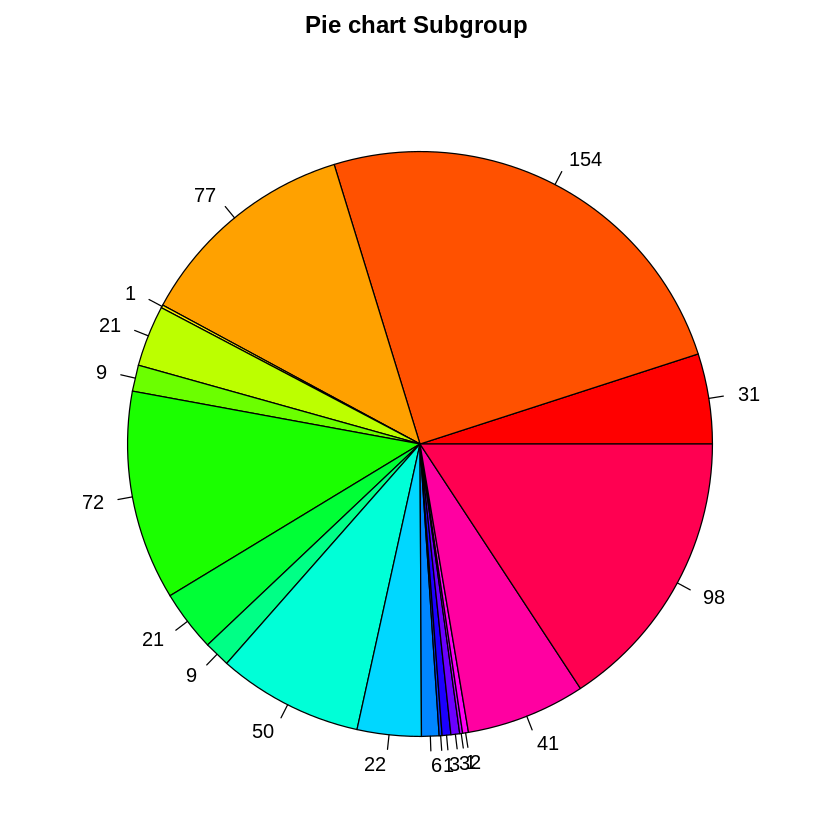

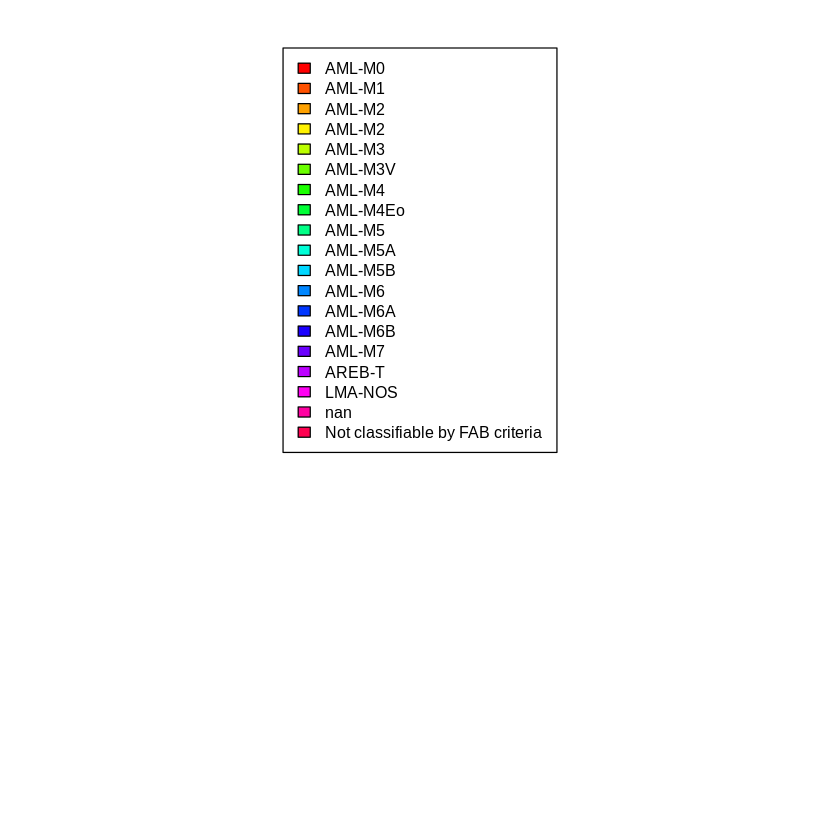

In [8]:
# count table
count_FAB = count(t_data_API, "dx_FAB")

# Pie chart
par(xpd=TRUE, mar=c(0,0,2,0))
pie(count_FAB$freq, main = "Pie chart Subgroup ",labels = count_FAB$freq, col = rainbow(length(count_FAB$freq)))
plot(1,type="n",axes=FALSE,xlab="",ylab="")
legend("top",legend = count_FAB$dx_FAB, cex = 0.8,ncol = 1,
       fill = rainbow(length(count_FAB$freq)),xpd=NA)


## % Blast

[1] 402

Warning message in hist(as.numeric(unfactor(t_data_API$`blasts_(%)`)), xlab = "blast (%)", :
“NAs introduced by coercion”

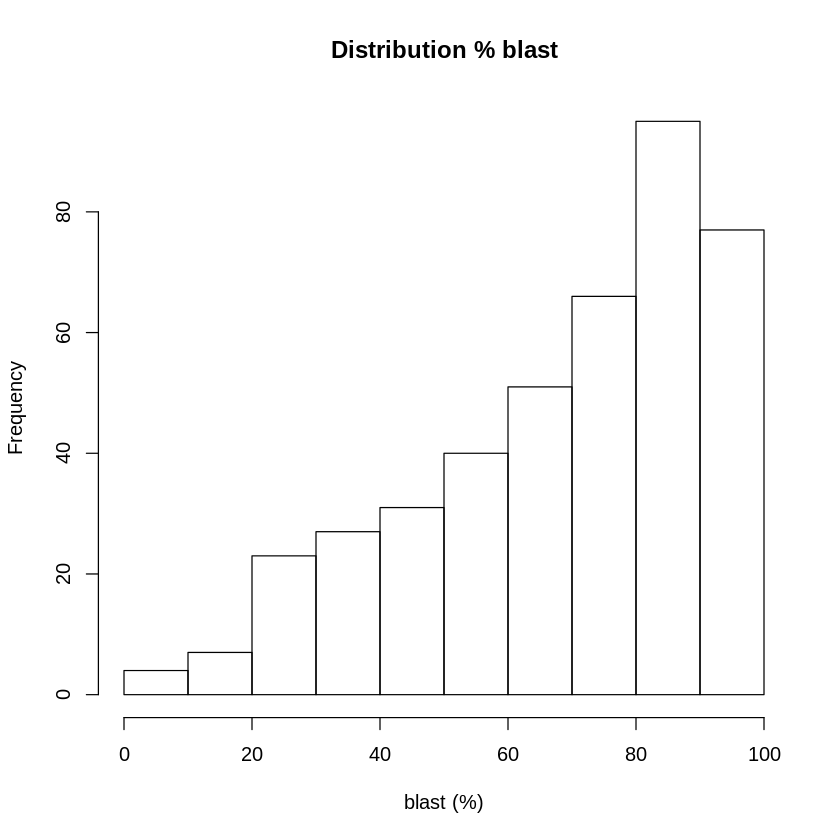

In [9]:
blast_sup_50 = row.names(t_data_API[which(unfactor(t_data_API$`blasts_(%)`)>50),])
#blast_sup_50 # Individus sequence avec un pourcentage de blast > 50 %
length(blast_sup_50) # Nombre d'individus sequence avec un pourcentage de blast > 50 %
hist(as.numeric(unfactor(t_data_API$`blasts_(%)`)),xlab = "blast (%)", main = "Distribution % blast")


## Analyse expression differentielle a partir des read count

In [10]:
adverse = row.names(t_data_API[which(unfactor(t_data_API$cytogenetic_risk)=="adverse cytogenetics"),])

intermediate = row.names(t_data_API[which(unfactor(t_data_API$cytogenetic_risk)=="intermediate cytogenetics"),])

favorable = row.names(t_data_API[which(unfactor(t_data_API$cytogenetic_risk)=="favorable cytogenetics"),])


In [11]:
read_count = read.table("/home/safia/Documents/AYA/genes_readcount.annotated.xls", header = T, sep="\t")

read_count<- data.frame(read_count[,-1], row.names=read_count[,1])
read_count = read_count[-c(1:4),]
read_count = read_count[,-c(582:585)]
names(read_count) = substring(names(read_count),8)


In [12]:
adverse = substring(adverse,2)
count_adverse = read_count[,adverse]

colnames(count_adverse) = paste("Adv", colnames(count_adverse), sep = "_")


In [13]:
intermediate = substring(intermediate,2)
count_intermediate = read_count[,intermediate]

colnames(count_intermediate) = paste("Int", colnames(count_intermediate), sep = "_")


In [14]:
favorable = substring(favorable,2)
count_favorable = read_count[,favorable]

colnames(count_favorable) = paste("Fav", colnames(count_favorable), sep = "_")


In [15]:
df = cbind(count_adverse,count_intermediate,count_favorable)

df_AI = cbind(count_adverse,count_intermediate)
df_AF = cbind(count_adverse,count_favorable)
df_IF = cbind(count_intermediate,count_favorable)

In [16]:
samples <- data.frame(groups = substr(colnames(df), 1, 3))

samples_AI <- data.frame(groups = substr(colnames(df_AI), 1, 3))
samples_AF <- data.frame(groups = substr(colnames(df_AF), 1, 3))
samples_IF <- data.frame(groups = substr(colnames(df_IF), 1, 3))

"base mean" (an average of the normalized mean counts per group), 
the log2 fold change between the groups, and the 
P-values (both "raw" and adjusted for multiple comparisons)

In [17]:
ds <- DESeqDataSetFromMatrix(countData=df, colData=samples, design=~groups)
colnames(ds) <- colnames(counts)
ds <-DESeq(ds)
res <- results(ds)
head(res)

estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 4393 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


log2 fold change (MLE): groups Int vs Adv 
Wald test p-value: groups Int vs Adv 
DataFrame with 6 rows and 6 columns
                           baseMean     log2FoldChange              lfcSE
                          <numeric>          <numeric>          <numeric>
ENSG00000223972.5  6.09002764659604  -1.13190128619525   0.15486393505103
ENSG00000227232.5  285.351198943538  0.315300765503667 0.0616992142422079
ENSG00000278267.1  18.6248463910603 -0.229546947611584 0.0811231362113446
ENSG00000243485.3  11.2409443348087 -0.365607657686481  0.127866819251648
ENSG00000274890.1                 0                 NA                 NA
ENSG00000237613.2 0.101221523341385 -0.376046459986776  0.827979258023824
                                stat               pvalue                 padj
                           <numeric>            <numeric>            <numeric>
ENSG00000223972.5   -7.3090050683671 2.69127619862591e-13 1.12182797183566e-11
ENSG00000227232.5   5.11028818399396 3.21667769040262e

In [ ]:
library("tidyr")

In [18]:
res <- results(ds, tidy=TRUE) %>%
  arrange(padj, pvalue) %>%
  tbl_df()
res

goi <- res$row[1:9]
stopifnot(all(goi %in% names(ds)))
goi

tcounts <- t(log2((counts(ds[goi, ], normalized=TRUE, replaced=FALSE)+.5))) %>%
  merge(colData(ds), ., by="row.names") %>%
  gather(gene, expression, (ncol(.)-length(goi)+1):ncol(.))

tcounts %>% 
  select(Row.names, groups, gene, expression) %>% 
  head %>% 
  knitr::kable()




ggplot(tcounts, aes(groups, expression, fill=groups)) + 
  geom_boxplot() + 
  facet_wrap(~gene, scales="free_y") + 
  labs(x="Cytogenetic risk", 
       y="Expression (log normalized counts)", 
       fill="Cytogenetic risk", 
       title="Top 9 Results")


ERROR: Error in tbl_df(.): could not find function "tbl_df"


In [ ]:
ds_AI <- DESeqDataSetFromMatrix(countData=df_AI, colData=samples_AI, design=~groups)
colnames(ds_AI) <- colnames(counts)
ds_AI <-DESeq(ds_AI)
res_AI <- results(ds_AI)
head(res_AI)

In [ ]:
ds_AF<- DESeqDataSetFromMatrix(countData=df_AF, colData=samples_AF, design=~groups)
colnames(ds_AF) <- colnames(counts)
ds_AF <-DESeq(ds_AF)
res_AF <- results(ds_AF)
head(res_AF)

In [ ]:
ds_IF <- DESeqDataSetFromMatrix(countData=df_IF, colData=samples_IF, design=~groups)
colnames(ds_IF) <- colnames(counts)
ds_IF <-DESeq(ds_IF)
res_IF <- results(ds_IF)
head(res_IF)

In [ ]:
write.table(res, "res_DE_AFI.xls", sep="\t") 
write.table(res_AI, "res_DE_AI.xls", sep="\t") 
write.table(res_AF, "res_DE_AF.xls", sep="\t") 
write.table(res_IF, "res_DE_FI.xls", sep="\t") 


#### Diagramm Venn

In [ ]:
res_AI = read.table("res_DE_AI.xls", sep="\t")

res_AF = read.table("res_DE_AF.xls", sep="\t")

res_FI = read.table("res_DE_FI.xls", sep="\t")

res_AFI = read.table("res_DE_AFI.xls", sep="\t")

In [ ]:
THRESHOLD <- 0.05
res_AI.sig <- subset(res_AI, padj<THRESHOLD) 
res_AF.sig <- subset(res_AF, padj<THRESHOLD)  
res_FI.sig <- subset(res_FI, padj<THRESHOLD) 
res_AFI.sig <- subset(res_AFI, padj<THRESHOLD)



In [ ]:
print(length(rownames(res_AI.sig)))
print(length(rownames(res_AF.sig)))
print(length(rownames(res_FI.sig)))
print(length(rownames(res_AFI.sig)))

In [ ]:
library(VennDiagram)

venn.plot <- venn.diagram(list(rownames(res_AI.sig), rownames(res_AF.sig), rownames(res_FI.sig), rownames(res_AFI.sig)), NULL, fill=c("red", "green","blue","yellow"), alpha=c(0.5,0.5,0.5,0.5), cex = 2, cat.fontface=4, category.names=c("Adverse vs Intermediate", "Adverse vs Favorable","Favorable vs Intermediate","Adverse vs Favorable vs Intermediate"))
grid.draw(venn.plot)


### SOUS GROUPE ADVERSE

In [6]:
adverse = row.names(t_data_API[which(unfactor(t_data_API$cytogenetic_risk)=="adverse cytogenetics"),])

In [7]:
API_Adv = t_data_API[adverse,]

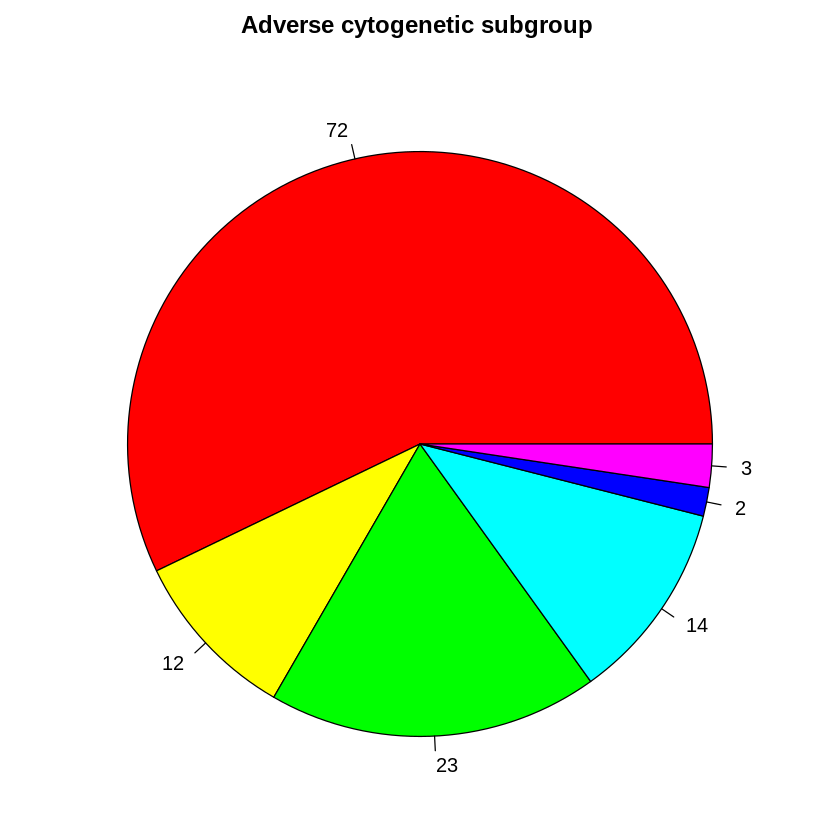

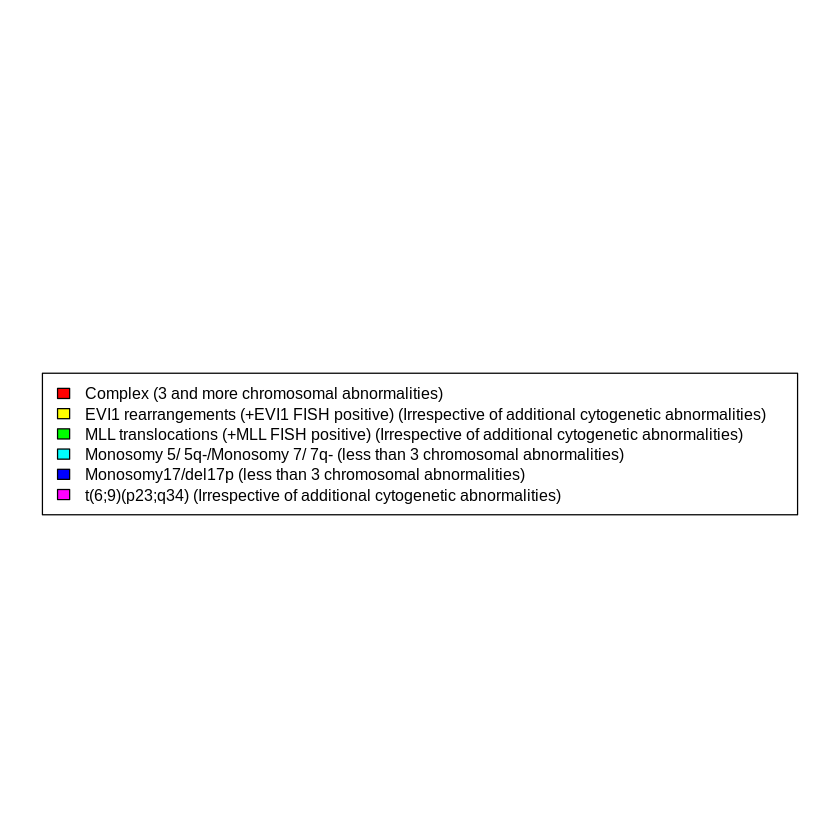

In [8]:
# count table
count_Adv_subgroup = count(API_Adv, "cytogenetic_subgroup")

# Pie chart

par(xpd=TRUE, mar=c(0,0,2,0))
pie(count_Adv_subgroup$freq, main = "Adverse cytogenetic subgroup ",labels = count_Adv_subgroup$freq, col = rainbow(length(count_Adv_subgroup$freq)))

plot(1,type="n",axes=FALSE,xlab="",ylab="")
legend("center",legend = count_Adv_subgroup$cytogenetic_subgroup, cex = 0.8,ncol = 1,
       fill = rainbow(length(count_Adv_subgroup$freq)),xpd=NA)



In [104]:
complex = row.names(API_Adv[which(unfactor(API_Adv$cytogenetic_subgroup)==count_Adv_subgroup$cytogenetic_subgroup[1]),])

mll = row.names(API_Adv[which(unfactor(API_Adv$cytogenetic_subgroup)==count_Adv_subgroup$cytogenetic_subgroup[3]),])

m5_m7 = row.names(API_Adv[which(unfactor(API_Adv$cytogenetic_subgroup)==count_Adv_subgroup$cytogenetic_subgroup[4]),])

m17 = row.names(API_Adv[which(unfactor(API_Adv$cytogenetic_subgroup)==count_Adv_subgroup$cytogenetic_subgroup[5]),])

t6_9 = row.names(API_Adv[which(unfactor(API_Adv$cytogenetic_subgroup)==count_Adv_subgroup$cytogenetic_subgroup[6]),])

### Classification groupe complexe

In [64]:
read_count = read.table("/home/safia/Documents/AYA/genes_readcount.annotated.xls", header = T, sep="\t")

read_count<- data.frame(read_count[,-1], row.names=read_count[,1])
read_count = read_count[-c(1:4),]
read_count = read_count[,-c(582:585)]
names(read_count) = substring(names(read_count),8)


In [65]:
complex = substring(complex,2)
count_complex = read_count[,complex]


In [66]:
cohort_IQR = apply(count_complex,1,IQR)

In [67]:
rank_cohort_IQR = rank(cohort_IQR)

In [68]:
ordered_IQR=rank_cohort_IQR[order(-rank_cohort_IQR)]

In [69]:
ordered_data=count_complex[order(-rank_cohort_IQR),]

In [70]:
tordered_data=t(ordered_data)


In [71]:
sample_dist=dist(tordered_data[,c(1:500)], method = "euclidean")

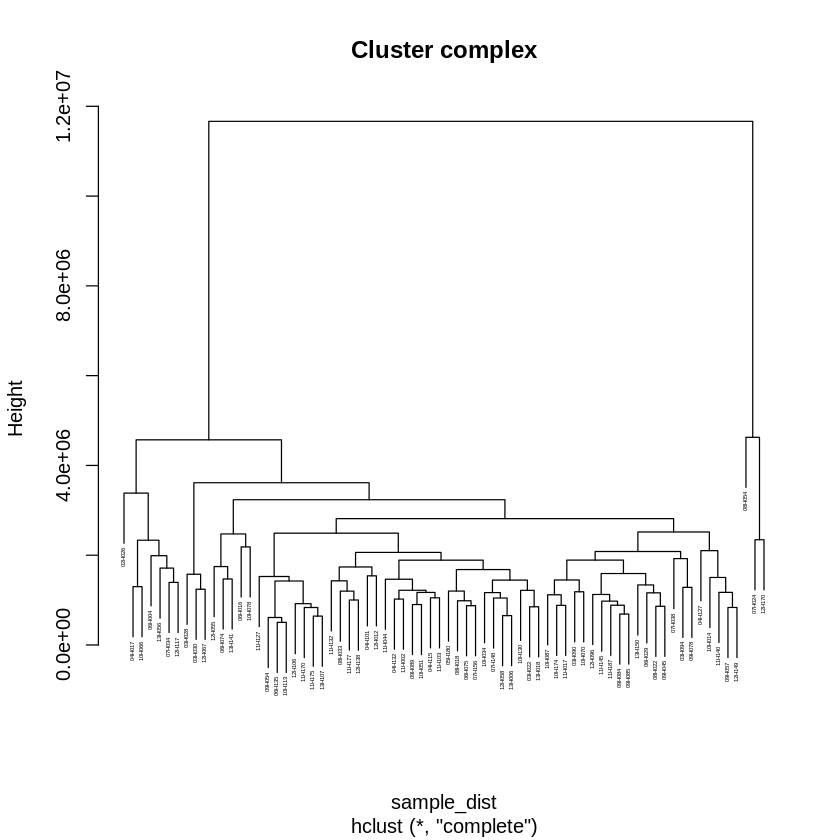

In [72]:
hc=hclust(sample_dist, method = "complete", members = NULL)

plot(hc, cex=0.3, main = "Cluster complex")

### information mutation p53

In [73]:
tp53_mutations = read.table("/home/safia/Documents/AYA/tp53_mutations.txt", header = T, sep="\t")

In [74]:
tp53 = colnames(tp53_mutations[2:171])
tp53 = substring(tp53,2)


In [75]:
count_tp53 = read_count[,tp53]

In [113]:
tp53_complex = cbind(count_complex,count_tp53)
cohort_IQR = apply(tp53_complex,1,IQR)
rank_cohort_IQR = rank(cohort_IQR)
ordered_IQR=rank_cohort_IQR[order(-rank_cohort_IQR)]
ordered_data=tp53_complex[order(-rank_cohort_IQR),]
tordered_data=t(ordered_data)


In [126]:
dim(tordered_data[,c(1:500)])

[1] 242 500

In [130]:
sample_dist_500=dist(tordered_data[,c(1:500)], method = "euclidean")
hc_500=hclust(sample_dist_500, method = "complete", members = NULL)
sample_dist_1000=dist(tordered_data[,c(1:1000)], method = "euclidean")
hc_1000=hclust(sample_dist_1000, method = "complete", members = NULL)

In [115]:
#install.packages("dendextend")
library(dendextend)

In [133]:
dend <- as.dendrogram(hc_500)
dend1 <- as.dendrogram(hc_1000)
# Here is a second way for doing the same thing:
dend2 <- color_labels(dend, col = ifelse(labels(hc) %in% tp53, 2, 1)) 
dend3 <- color_labels(dend1, col = ifelse(labels(hc) %in% tp53, 2, 1)) 

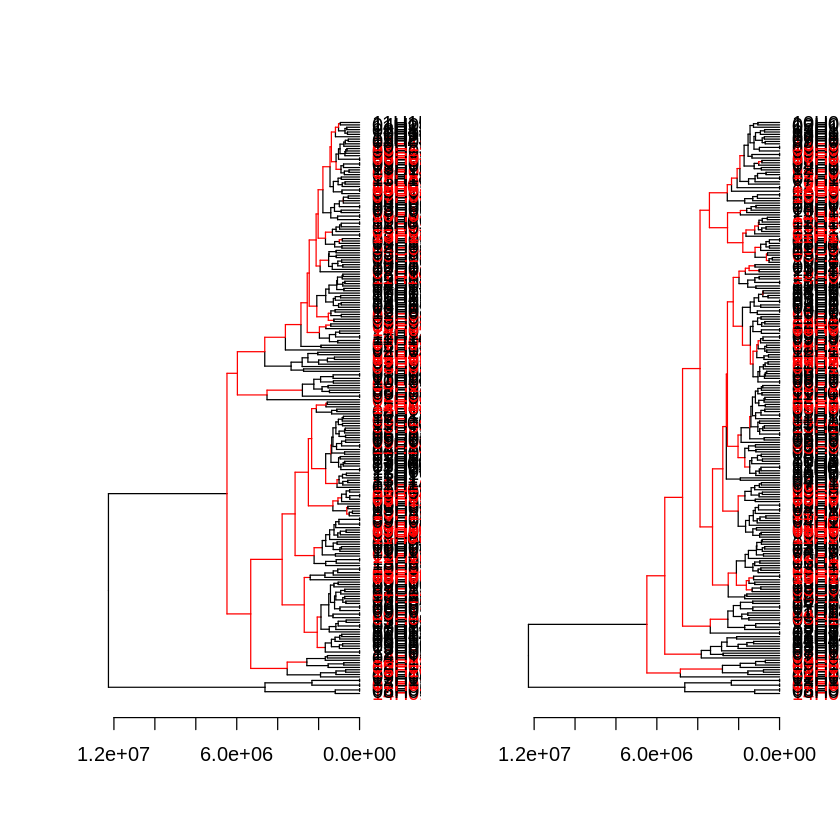

In [136]:
dend_diff(dend2, dend3)

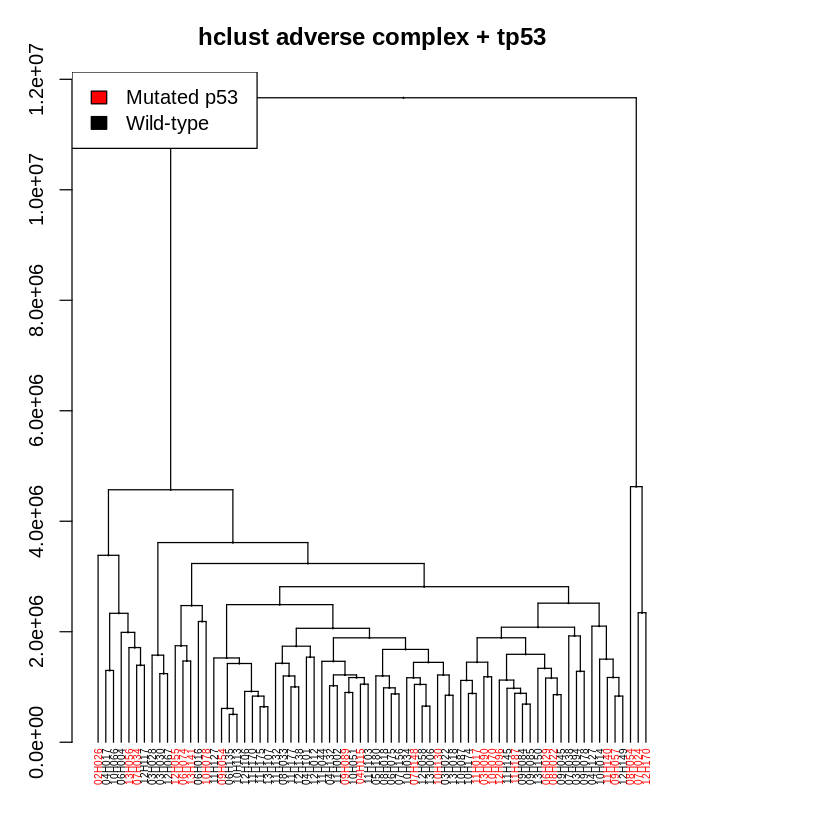

In [81]:

par(mar = c(3,3,3,7))
dend2 %>%   set("labels_cex", 0.5) %>% # Change size
  plot(main = "hclust adverse complex + tp53", 
       nodePar = list(cex = .007)) # plot
legend("topleft", legend = c("Mutated p53","Wild-type"), fill = c("red","black"))

### complex + 5 MLL

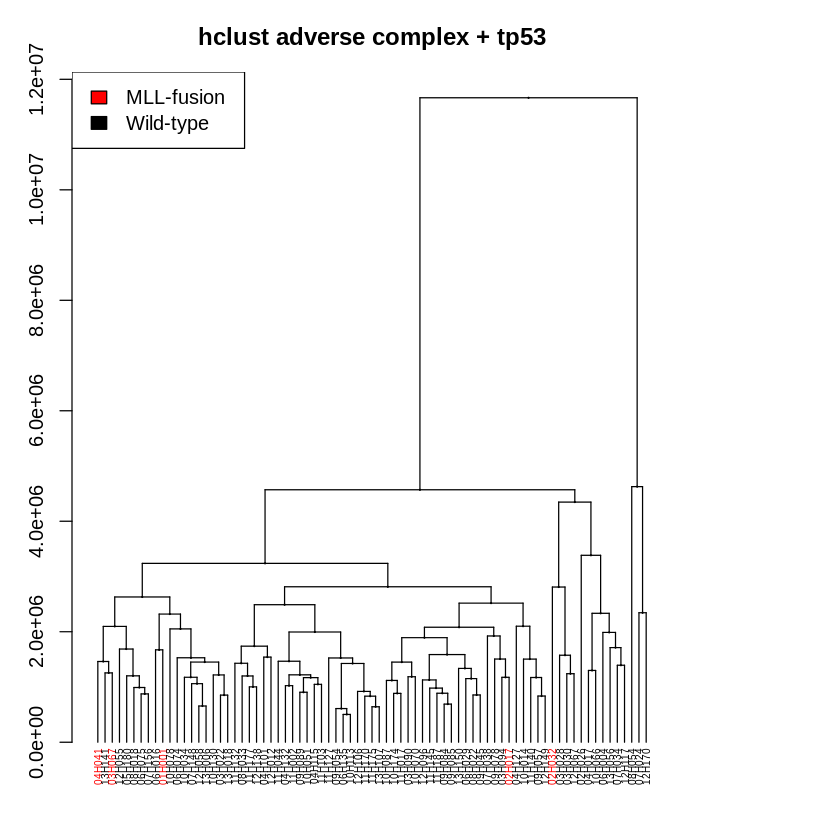

In [105]:
mll = substring(mll,2)
count_mll = read_count[,mll[1:5]]
mll_complex = cbind(count_complex,count_mll)
cohort_IQR = apply(mll_complex,1,IQR)
rank_cohort_IQR = rank(cohort_IQR)
ordered_IQR=rank_cohort_IQR[order(-rank_cohort_IQR)]
ordered_data=mll_complex[order(-rank_cohort_IQR),]
tordered_data=t(ordered_data)
sample_dist_500=dist(tordered_data[,c(1:500)], method = "euclidean")
hc_500=hclust(sample_dist_500, method = "complete", members = NULL)
dend <- as.dendrogram(hc_500)

# Here is a second way for doing the same thing:
dend2 <- color_labels(dend, col = ifelse(labels(hc_500) %in% mll, 2, 1)) 

par(mar = c(3,3,3,7))
dend2 %>%   set("labels_cex", 0.5) %>% # Change size
  plot(main = "hclust adverse complex + tp53", 
       nodePar = list(cex = .007)) # plot
legend("topleft", legend = c("MLL-fusion","Wild-type"), fill = c("red","black"))

### Complex + 5 MLL + tp53

In [ ]:
tp53_mll_complex = cbind(count_complex,count_mll,count_tp53)
cohort_IQR = apply(tp53_mll_complex,1,IQR)
rank_cohort_IQR = rank(cohort_IQR)
ordered_IQR=rank_cohort_IQR[order(-rank_cohort_IQR)]
ordered_data=tp53_mll_complex[order(-rank_cohort_IQR),]
tordered_data=t(ordered_data)
sample_dist_500=dist(tordered_data[,c(1:500)], method = "euclidean")
hc_500=hclust(sample_dist_500, method = "complete", members = NULL)
dend <- as.dendrogram(hc_500)



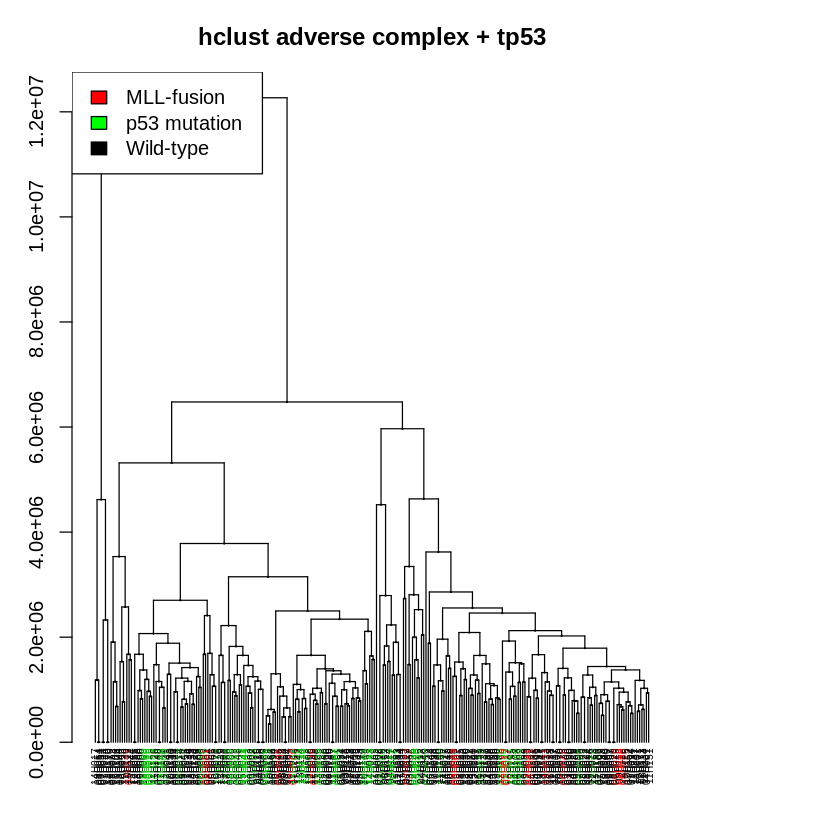

In [111]:
# Here is a second way for doing the same thing:
dend2 <- color_labels(dend, col = ifelse(labels(hc_500) %in% mll , 2 , ifelse(labels(hc_500) %in% tp53, 1, 3))) 

par(mar = c(3,3,3,7))
dend2 %>%   set("labels_cex", 0.5) %>% # Change size
  plot(main = "hclust adverse complex + tp53", 
       nodePar = list(cex = .007)) # plot
legend("topleft", legend = c("MLL-fusion","p53 mutation","Wild-type"), fill = c("red","green","black"))

#### Differential analysis

In [ ]:
read_count = read.table("/home/safia/Documents/AYA/genes_readcount.annotated.xls", header = T, sep="\t")
read_count<- data.frame(read_count[,-1], row.names=read_count[,1])
read_count = read_count[-c(1:4),]
read_count = read_count[,-c(582:585)]
names(read_count) = substring(names(read_count),8)


adverse = substring(adverse,2)
count_adverse = read_count[,adverse]
colnames(count_adverse) = paste("Adv", colnames(count_adverse), sep = "_")


intermediate = substring(intermediate,2)
count_intermediate = read_count[,intermediate]
colnames(count_intermediate) = paste("Int", colnames(count_intermediate), sep = "_")


favorable = substring(favorable,2)
count_favorable = read_count[,favorable]
colnames(count_favorable) = paste("Fav", colnames(count_favorable), sep = "_")


df = cbind(count_adverse,count_intermediate,count_favorable)



samples <- data.frame(groups = substr(colnames(df), 1, 3))


ds <- DESeqDataSetFromMatrix(countData=df, colData=samples, design=~groups)
colnames(ds) <- colnames(counts)
ds <-DESeq(ds)
res <- results(ds)
head(res)

write.table(res, "res_DE_AFI.xls", sep="\t") 